In [1]:
with open("./data.txt", "r") as data_file:
    data = data_file.read()

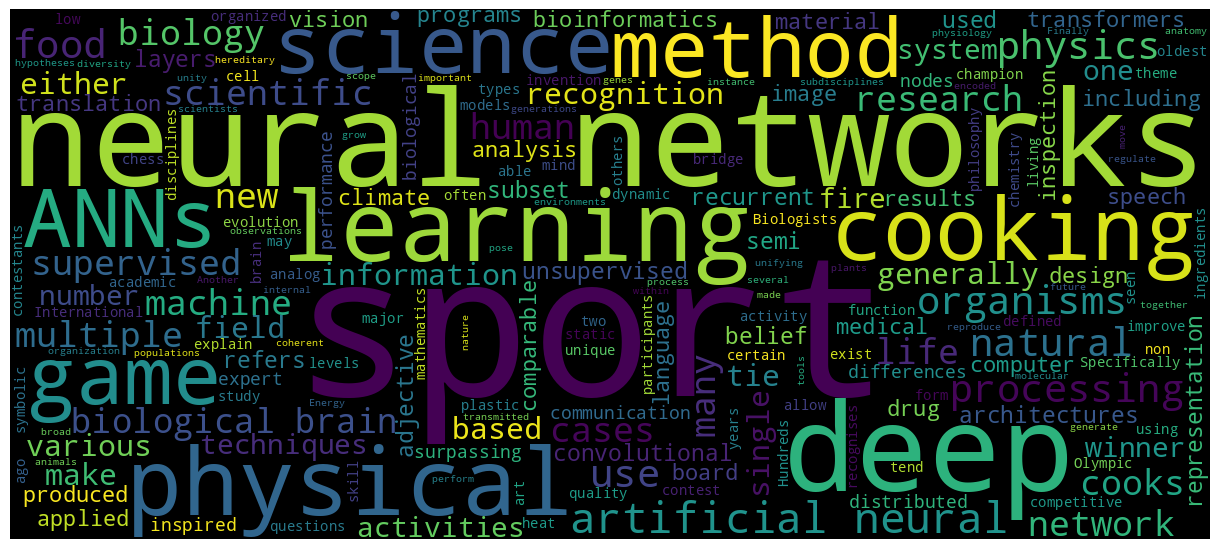

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(width=1200, height=530, background_color="black").generate(data)

plt.figure(figsize=(12, 5.3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

In [2]:
import re

# Clean the data
def clean_and_tokenize(text):
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    cleaned_text = cleaned_text.lower()
    tokens = cleaned_text.split(' ')
    with open("./stopwords-en.txt", "r") as f:
        stop_words = f.read()
    stop_words = stop_words.replace('\n', ' ').split(' ')
    return [token for token in tokens if token not in stop_words][:-1]

tokens = clean_and_tokenize(data)

In [3]:
unique_words = set(tokens)
# dicts for word to id and vice versa
word_id = {word:i for (i,word) in enumerate(unique_words)}
id_word = {i:word for (i,word) in enumerate(unique_words)}

## Training Data

In [4]:
window_size = 2

def target_context_tuples(tokens, window_size):
    context = []
    for i, token in enumerate(tokens):
        context_words = [t for t in merge(tokens, i, window_size) if t != token]
        for c in context_words:
            context.append((token, c))
    return context


def merge(tokens, i, window_size):
    left_id = i - window_size if i >= window_size else i - 1 if i != 0 else i
    right_id = i + window_size + 1 if i + window_size <= len(tokens) else len(tokens)
    return tokens[left_id:right_id]

In [5]:
target_context_pairs = target_context_tuples(tokens, 2)
target_context_pairs[:20]

[('deep', 'learning'),
 ('deep', 'subset'),
 ('learning', 'deep'),
 ('learning', 'subset'),
 ('learning', 'machine'),
 ('subset', 'deep'),
 ('subset', 'learning'),
 ('subset', 'machine'),
 ('subset', 'learning'),
 ('machine', 'learning'),
 ('machine', 'subset'),
 ('machine', 'learning'),
 ('machine', 'methods'),
 ('learning', 'subset'),
 ('learning', 'machine'),
 ('learning', 'methods'),
 ('learning', 'based'),
 ('methods', 'machine'),
 ('methods', 'learning'),
 ('methods', 'based')]

In [6]:
import pandas as pd
df = pd.DataFrame(target_context_pairs, columns=["target","context"])
df.head()

,target,context
0,deep,learning
1,deep,subset
2,learning,deep
3,learning,subset
4,learning,machine


Obviously our model can't take strings as input, we'll need to one hot encode the words first.

In [8]:
import torch.nn.functional as F
import torch

vocab_size = len(unique_words)
token_indexes = [word_id[token] for token in unique_words]
encodings = F.one_hot(torch.tensor(token_indexes), num_classes=vocab_size).float()

df["target_ohe"] = df["target"].apply(lambda x : encodings[word_id[x]])
df["context_ohe"] = df["context"].apply(lambda x : encodings[word_id[x]])

In [ ]:
from torch.utils.data import Dataset

class W2VDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        context = df["context_ohe"][idx]
        target = df["target_ohe"][idx]
        return context, target

dataset = W2VDataset(df)

print(len(dataset))
print(dataset[2])

In [12]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
import torch

class Word2Vec(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.linear1 = torch.nn.Linear(vocab_size, embed_size)
        self.linear2 = torch.nn.Linear(embed_size, vocab_size, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = Word2Vec()
model

In [14]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBED_SIZE = 10
model = Word2Vec(vocab_size, EMBED_SIZE)
model.to(device)
LR = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
epochs = 300

loss_values = []
for epoch in range(epochs):
    running_loss = 0.0
    # model.train() # no need since model is in train mode by default
    for batch, (context, target) in enumerate(dataloader):
        context = context.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        pred = model(context)
        loss = loss_fn(pred, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss/len(dataloader)
    if (epoch+1)%10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss}")

    loss_values.append(epoch_loss)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title("Loss curve")
plt.xlabel("epochs")
plt.ylabel("Loss")

In [ ]:
def get_word_embedding(model, word):
    # embeddings = model.embeds.weight.detach().cpu()
    embeddings = model.linear2.weight.detach().cpu()
    id = word_id[word]
    return embeddings[id]

get_word_embedding(model, "biology")

In [20]:
word = encodings[word_id["food"]]
[id_word[id.item()] for id in torch.argsort(model(word.to(device)), descending=True).squeeze(0)[:5]]

['heat', 'preparing', 'fire', 'establishments', 'digestible']

In [25]:
words = ["life", "computer", "physics", "food"]
enc = [encodings[word_id[w]] for w in words]

sim_words = []
for e in enc:
    sim_words.append([id_word[id.item()] for id in torch.argsort(model(e.to(device)), descending=True).squeeze(0)[:5]])

for w,s in zip(words, sim_words):
    print(f"{w}: {s}")

life: ['study', 'organisms', 'earth', 'emerged', 'energy']
computer: ['fields', 'speech', 'vision', 'including', 'computer']
physics: ['nuclear', 'physicist', 'chemistry', 'often', 'called']
food: ['heat', 'preparing', 'fire', 'establishments', 'digestible']
